# IT1244 Project

## Import Libraries

In [ ]:
import re as re
import heapq as heapq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import random as random
from sklearn.preprocessing import StandardScaler
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.decomposition import PCA
import torch as torch
from transformers import AutoModel
from transformers import AutoTokenizer, BertTokenizerFast
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [1]:
def accuracy_score(y_test, y_pred):
    return sum(y_test == y_pred)/len(y_test)

In [2]:
def metrics(y_true, y_guess, table = False, model_name = "", digits=4):
    CM = confusion_matrix(y_true, y_guess)
    TN, FN, TP, FP =  CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    accuracy = np.round((TP+TN)/(TP+TN+FP+FN), digits)
    precision = np.round(TP/(TP+FP), digits)
    recall =  np.round(TP/(TP+FN), digits)
    f1_score =  np.round(2*(precision*recall)/(precision+recall), digits)
    if not table:
        return accuracy, precision, recall, f1_score
    else:
        if not model_name:
            return pd.DataFrame({'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})
        else:
            return pd.DataFrame({'model':[model_name], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1_score': [f1_score]})

## Data Importing

In [5]:
tweets = pd.read_csv("../Data/Raw/dataset.csv", header=None)
tweets.head()

NameError: name 'pd' is not defined

### Bert Encoding

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=True)
model = AutoModel.from_pretrained('vinai/bertweet-base')

In [ ]:
def bert_encode(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :]


In [ ]:
sentence_vectors = tweets[1].apply(lambda x: bert_encode(x))
data = np.array(list(map(lambda x: x[0], sentence_vectors)))
data_frame = pd.DataFrame(data)
data_frame.to_csv("../Data/Cleaned/BERT_Vectors.csv")

### Read the CSV data file

In [ ]:
Bert_Encoded_Text = pd.read_csv("../Data/Cleaned/BERT_Vectors.csv").iloc[: , 1:]
X = Bert_Encoded_Text
y = tweets[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest Model

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
RFC = clf.fit(X_train, y_train)
y_hat = RFC.predict(X_test)
y_pred1 = y_hat

In [ ]:
def convert(y_test):
    return np.array(list(map(lambda x: x[0], y_test)))

In [ ]:
accuracy_score(y_test, y_pred1)

0.7181

In [ ]:
metrics(y_test, y_hat, table = True, model_name="Random Forest")

,model,accuracy,precision,recall,f1_score
0,Random Forest,0.7181,0.7178,0.7199,0.7188


### K-NN Model

#### N-fold Cross validation

In [ ]:
k_values = [i for i in range(1, 50, 2)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

In [ ]:
results = list(map(lambda x: float(x), scores))

Text(0, 0.5, 'Cross-Validation Score')

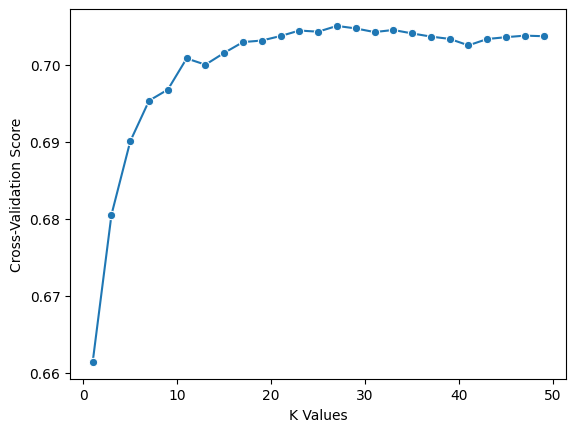

In [ ]:
sns.lineplot(x = k_values, y = results, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [ ]:
#optimal k is k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
cross_val_score(knn, X_train, y_train, cv=5)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:239: 

array([0.695875 , 0.6938125, 0.692375 , 0.6945   , 0.6905625])

In [ ]:
yhat_pred = knn.predict(X_test) > 0.5
y_pred2 = yhat_pred

In [ ]:
metrics(y_test, yhat_pred, table = True, model_name="K-NN")

,model,accuracy,precision,recall,f1_score
0,K-NN,0.69045,0.685813,0.698685,0.692189


## Deep Learning Neural Network

In [ ]:
def accuracy_val(model):
    y_hat = model.predict(X_test)
    return float((sum((y_hat >= 0.5) == y_test)/len(y_test))[0])*100

In [ ]:
def accuracy_train(model):
    y_hat = model.predict(X_train)
    return float((sum((y_hat >= 0.5) == y_train)/len(y_train))[0])*100

In [ ]:
X.shape

(100000, 768)

In [ ]:
y = np.array(y)
y = y.reshape(-1, 1)
y.shape

(100000, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='gelu'))
model.add(Dense(512, activation='gelu'))
model.add(Dense(512, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.7560 - loss: 0.4937 - val_accuracy: 0.8057 - val_loss: 0.4226
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8331 - loss: 0.3712 - val_accuracy: 0.8111 - val_loss: 0.4136
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.8562 - loss: 0.3252 - val_accuracy: 0.8084 - val_loss: 0.4347
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.8827 - loss: 0.2702 - val_accuracy: 0.7975 - val_loss: 0.4810
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9122 - loss: 0.2074 - val_accuracy: 0.7927 - val_loss: 0.5637
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9406 - loss: 0.1497 - val_accuracy: 0.7907 - val_loss: 0.6543
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9566 - loss: 0.1121 - val_accuracy: 0.7869 - val_loss: 0.7142
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.9694 -

In [ ]:
import pydot

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)
model.summary()
accuracy_val(model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,758,661 (10.52 MB)

 Trainable params: 919,553 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,839,108 (7.02 MB)

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


78.73

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model.add(Dense(512, input_dim=768, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.7121 - loss: 0.5585 - val_accuracy: 0.8002 - val_loss: 0.4325
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.8091 - loss: 0.4196 - val_accuracy: 0.8084 - val_loss: 0.4201
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8218 - loss: 0.3955 - val_accuracy: 0.8109 - val_loss: 0.4106
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8313 - loss: 0.3776 - val_accuracy: 0.8156 - val_loss: 0.4012
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.8380 - loss: 0.3654 - val_accuracy: 0.8181 - val_loss: 0.4028
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.8410 - loss: 0.3552 - val_accuracy: 0.8158 - val_loss: 0.4057
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.8447 - loss: 0.3497 - val_accuracy: 0.8181 - val_loss: 0.4047
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.8485 -

In [ ]:
accuracy_val(model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


81.89

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model0 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model0.add(Dense(512, input_dim=768, activation='gelu'))
model0.add(Dropout(0.3))  # Dropout to prevent overfitting
model0.add(Dense(256, activation='gelu'))
model0.add(Dropout(0.3))
model0.add(Dense(128, activation='gelu'))
model0.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model0.add(Dense(1, activation='sigmoid'))

# Compile the model
model0.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model0.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.7223 - loss: 0.5440 - val_accuracy: 0.8041 - val_loss: 0.4266
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.8132 - loss: 0.4127 - val_accuracy: 0.8111 - val_loss: 0.4185
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8240 - loss: 0.3899 - val_accuracy: 0.8144 - val_loss: 0.4116
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8375 - loss: 0.3695 - val_accuracy: 0.8166 - val_loss: 0.4081
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.8409 - loss: 0.3597 - val_accuracy: 0.8157 - val_loss: 0.4074
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8475 - loss: 0.3476 - val_accuracy: 0.8147 - val_loss: 0.4068
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8543 - loss: 0.3346 - val_accuracy: 0.8167 - val_loss: 0.4112
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8565 -

In [ ]:
accuracy_val(model0)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


81.84

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model1 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model1.add(Dense(512, input_dim=768, activation='relu'))
model1.add(Dropout(0.3))  # Dropout to prevent overfitting
model1.add(Dense(256, activation='gelu'))
model1.add(Dropout(0.3))
model1.add(Dense(128, activation='mish'))
model1.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7231 - loss: 0.5461 - val_accuracy: 0.8059 - val_loss: 0.4230
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8119 - loss: 0.4157 - val_accuracy: 0.8109 - val_loss: 0.4119
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8247 - loss: 0.3919 - val_accuracy: 0.8152 - val_loss: 0.4076
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8322 - loss: 0.3771 - val_accuracy: 0.8157 - val_loss: 0.4045
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8411 - loss: 0.3631 - val_accuracy: 0.8176 - val_loss: 0.4031
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8428 - loss: 0.3542 - val_accuracy: 0.8154 - val_loss: 0.4050
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8500 - loss: 0.3405 - val_accuracy: 0.8161 - val_loss: 0.4107
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8505 -

In [ ]:
accuracy_val(model1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


81.61

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model2 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model2.add(Dense(512, input_dim=768, activation='gelu'))
model2.add(Dropout(0.3))  # Dropout to prevent overfitting
model2.add(Dense(256, activation='gelu'))
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='gelu'))
model2.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.7349 - loss: 0.5309 - val_accuracy: 0.7985 - val_loss: 0.4406
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8102 - loss: 0.4153 - val_accuracy: 0.8079 - val_loss: 0.4123
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3431s 3s/step - accuracy: 0.8267 - loss: 0.3913 - val_accuracy: 0.8135 - val_loss: 0.4108
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8332 - loss: 0.3764 - val_accuracy: 0.8133 - val_loss: 0.4205
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8381 - loss: 0.3687 - val_accuracy: 0.8169 - val_loss: 0.4044
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8420 - loss: 0.3555 - val_accuracy: 0.8192 - val_loss: 0.4091
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8458 - loss: 0.3511 - val_accuracy: 0.8193 - val_loss: 0.4054
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.8485 -

In [ ]:
accuracy_val(model2)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


81.88

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model3 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model3.add(Dense(512, input_dim=768, activation='gelu'))
model3.add(Dense(512, input_dim=768, activation='mish'))
model3.add(Dropout(0.3))  # Dropout to prevent overfitting
model3.add(Dense(256, activation='gelu'))
model3.add(Dense(256, activation='tanh'))
model3.add(Dropout(0.3))
model3.add(Dense(128, activation='gelu'))
model3.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8581 - loss: 0.3186 - val_accuracy: 0.8183 - val_loss: 0.4270
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8584 - loss: 0.3118 - val_accuracy: 0.8175 - val_loss: 0.4199
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8657 - loss: 0.3003 - val_accuracy: 0.8136 - val_loss: 0.4362
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8708 - loss: 0.2894 - val_accuracy: 0.8165 - val_loss: 0.4358
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8739 - loss: 0.2843 - val_accuracy: 0.8146 - val_loss: 0.4298
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8773 - loss: 0.2770 - val_accuracy: 0.8123 - val_loss: 0.4571
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8777 - loss: 0.2757 - val_accuracy: 0.8117 - val_loss: 0.4376
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8789 -

In [ ]:
accuracy_val(model3)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


47.795

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
model4 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model4.add(Dense(512, input_dim=768, activation='mish'))
model4.add(Dropout(0.3))  # Dropout to prevent overfitting
model4.add(Dense(256, activation='tanh'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation='gelu'))
model4.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
model4.add(Dense(1, activation='sigmoid'))

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model4.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7433 - loss: 0.5181 - val_accuracy: 0.8067 - val_loss: 0.4278
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8149 - loss: 0.4117 - val_accuracy: 0.8124 - val_loss: 0.4095
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8252 - loss: 0.3905 - val_accuracy: 0.8181 - val_loss: 0.4030
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8285 - loss: 0.3796 - val_accuracy: 0.8161 - val_loss: 0.4022
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8375 - loss: 0.3677 - val_accuracy: 0.8140 - val_loss: 0.4088
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8396 - loss: 0.3608 - val_accuracy: 0.8146 - val_loss: 0.4102
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 778s 779ms/step - accuracy: 0.8405 - loss: 0.3527 - val_accuracy: 0.8167 - val_loss: 0.4160
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8430

In [ ]:
accuracy_val(model4)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


81.82000000000001

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model5 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model5.add(Dense(64, input_dim=768, activation='mish'))
model5.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model5.add(Dense(1, activation='sigmoid'))

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model5.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7197 - loss: 0.5579 - val_accuracy: 0.8036 - val_loss: 0.4261
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8098 - loss: 0.4206 - val_accuracy: 0.8096 - val_loss: 0.4121
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8197 - loss: 0.3986 - val_accuracy: 0.8112 - val_loss: 0.4104
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8249 - loss: 0.3890 - val_accuracy: 0.8168 - val_loss: 0.4029
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8291 - loss: 0.3813 - val_accuracy: 0.8181 - val_loss: 0.4023
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8371 - loss: 0.3707 - val_accuracy: 0.8175 - val_loss: 0.3999
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8380 - loss: 0.3684 - val_accuracy: 0.8172 - val_loss: 0.4017
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8394 - loss: 0.3632 - 

In [ ]:
accuracy_val(model5)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


82.285

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (80,000, 1)

# Model architecture
model6 = Sequential()

# Input layer: (768,) is the shape of each BERT vector
model6.add(Dense(64, input_dim=768, activation='gelu'))
model6.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer: single neuron with sigmoid activation for binary classification
model6.add(Dense(1, activation='sigmoid'))

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model6.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7180 - loss: 0.5658 - val_accuracy: 0.8005 - val_loss: 0.4314
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8089 - loss: 0.4176 - val_accuracy: 0.8117 - val_loss: 0.4119
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8194 - loss: 0.4007 - val_accuracy: 0.8131 - val_loss: 0.4102
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8277 - loss: 0.3843 - val_accuracy: 0.8159 - val_loss: 0.4036
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8299 - loss: 0.3810 - val_accuracy: 0.8198 - val_loss: 0.4010
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8388 - loss: 0.3666 - val_accuracy: 0.8159 - val_loss: 0.4018
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8410 - loss: 0.3631 - val_accuracy: 0.8168 - val_loss: 0.4044
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8433 - loss: 0.3593 - 

In [ ]:
accuracy_val(model6)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


81.94

In [ ]:
from tensorflow.keras.regularizers import l1_l2

model7 = Sequential()
model7.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model7.add(Dropout(0.3))  # Dropout to prevent overfitting
model7.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model7.add(Dense(1, activation='sigmoid'))

# Compile the model
model7.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model7.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6285 - loss: 2.6566 - val_accuracy: 0.7311 - val_loss: 0.7068
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7058 - loss: 0.7028 - val_accuracy: 0.7479 - val_loss: 0.6647
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7171 - loss: 0.6826 - val_accuracy: 0.7590 - val_loss: 0.6549
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7228 - loss: 0.6763 - val_accuracy: 0.7579 - val_loss: 0.6443
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7245 - loss: 0.6710 - val_accuracy: 0.7602 - val_loss: 0.6412
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7279 - loss: 0.6650 - val_accuracy: 0.7601 - val_loss: 0.6390
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7314 - loss: 0.6600 - val_accuracy: 0.7553 - val_loss: 0.6374
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7290 - loss: 0.6596 - 

In [ ]:
accuracy_val(model7)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


76.67

In [ ]:
model8 = Sequential()
model8.add(Dense(16, input_dim=768, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model8.add(Dropout(0.3))  # Dropout to prevent overfitting
model8.add(Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model8.add(Dense(1, activation='sigmoid'))

# Compile the model
model8.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model8.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5499 - loss: 2.8034 - val_accuracy: 0.5019 - val_loss: 0.7162
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5008 - loss: 0.7045 - val_accuracy: 0.5019 - val_loss: 0.6998
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4991 - loss: 0.6999 - val_accuracy: 0.5019 - val_loss: 0.6999
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4977 - loss: 0.7000 - val_accuracy: 0.5019 - val_loss: 0.7000
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5038 - loss: 0.7001 - val_accuracy: 0.4981 - val_loss: 0.7002
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5006 - loss: 0.7002 - val_accuracy: 0.4981 - val_loss: 0.7003
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4980 - loss: 0.7003 - val_accuracy: 0.4981 - val_loss: 0.7003
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5014 - loss: 0.7003 - 

In [ ]:
accuracy_val(model8)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


50.185

In [ ]:
model9 = Sequential()
model9.add(Dense(16, input_dim=768, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model9.add(Dropout(0.3))  # Dropout to prevent overfitting
model9.add(Dense(16, activation='gelu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

# Output layer: single neuron with sigmoid activation for binary classification
model9.add(Dense(1, activation='sigmoid'))

# Compile the model
model9.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model9.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6037 - loss: 2.4920 - val_accuracy: 0.5019 - val_loss: 0.7059
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4969 - loss: 0.7010 - val_accuracy: 0.4981 - val_loss: 0.6995
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4985 - loss: 0.6995 - val_accuracy: 0.4981 - val_loss: 0.6995
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4977 - loss: 0.6995 - val_accuracy: 0.5019 - val_loss: 0.6995
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4994 - loss: 0.6995 - val_accuracy: 0.5019 - val_loss: 0.6995
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4980 - loss: 0.6996 - val_accuracy: 0.5019 - val_loss: 0.6997
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5018 - loss: 0.6997 - val_accuracy: 0.4981 - val_loss: 0.6997
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5032 - loss: 0.6997 - 

In [ ]:
accuracy_val(model9)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


50.185

In [ ]:
model10 = Sequential()
model10.add(Dense(16, input_dim=768, activation='gelu'))
model10.add(Dropout(0.3))  # Dropout to prevent overfitting
model10.add(Dense(16, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model10.add(Dense(1, activation='sigmoid'))

# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model10.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model10)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6889 - loss: 0.5886 - val_accuracy: 0.7914 - val_loss: 0.4499
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7926 - loss: 0.4466 - val_accuracy: 0.8056 - val_loss: 0.4246
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8091 - loss: 0.4214 - val_accuracy: 0.8098 - val_loss: 0.4185
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8114 - loss: 0.4120 - val_accuracy: 0.8145 - val_loss: 0.4097
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8175 - loss: 0.4062 - val_accuracy: 0.8146 - val_loss: 0.4084
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8226 - loss: 0.3966 - val_accuracy: 0.8157 - val_loss: 0.4047
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8240 - loss: 0.3953 - val_accuracy: 0.8198 - val_loss: 0.4040
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8274 - loss: 0.3868 - 

81.695

In [ ]:
model11 = Sequential()
model11.add(Dense(16, input_dim=768, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(8, activation='gelu'))
model11.add(Dropout(0.3))  # Dropout to prevent overfitting
model11.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model11.add(Dense(1, activation='sigmoid'))

# Compile the model
model11.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model11.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model11)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6117 - loss: 0.7043 - val_accuracy: 0.7574 - val_loss: 0.4887
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7532 - loss: 0.5106 - val_accuracy: 0.7926 - val_loss: 0.4394
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7857 - loss: 0.4629 - val_accuracy: 0.8023 - val_loss: 0.4230
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8012 - loss: 0.4396 - val_accuracy: 0.8082 - val_loss: 0.4176
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8122 - loss: 0.4244 - val_accuracy: 0.8129 - val_loss: 0.4111
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8133 - loss: 0.4143 - val_accuracy: 0.8130 - val_loss: 0.4077
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8195 - loss: 0.4119 - val_accuracy: 0.8152 - val_loss: 0.4090
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8210 - loss: 0.4

81.83

In [ ]:
model12 = Sequential()
model12.add(Dense(16, input_dim=768, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(8, activation='mish'))
model12.add(Dropout(0.3))  # Dropout to prevent overfitting
model12.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model12.add(Dense(1, activation='sigmoid'))

# Compile the model
model12.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model12.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model12)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6294 - loss: 0.6409 - val_accuracy: 0.7786 - val_loss: 0.4735
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7773 - loss: 0.4826 - val_accuracy: 0.8024 - val_loss: 0.4317
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8015 - loss: 0.4465 - val_accuracy: 0.8075 - val_loss: 0.4204
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8105 - loss: 0.4291 - val_accuracy: 0.8129 - val_loss: 0.4127
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8180 - loss: 0.4194 - val_accuracy: 0.8144 - val_loss: 0.4101
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8179 - loss: 0.4189 - val_accuracy: 0.8134 - val_loss: 0.4083
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8202 - loss: 0.4104 - val_accuracy: 0.8152 - val_loss: 0.4089
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8230 - loss: 0.4051 - 

81.865

In [ ]:
model13 = Sequential()
model13.add(Dense(16, input_dim=768, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(8, activation='mish'))
model13.add(Dropout(0.3))  # Dropout to prevent overfitting
model13.add(Dense(4, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model13.add(Dense(1, activation='sigmoid'))

# Compile the model
model13.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model13.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model13)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5730 - loss: 0.6931 - val_accuracy: 0.7200 - val_loss: 0.5641
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7033 - loss: 0.5745 - val_accuracy: 0.7563 - val_loss: 0.5089
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7415 - loss: 0.5297 - val_accuracy: 0.7769 - val_loss: 0.4747
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7666 - loss: 0.5011 - val_accuracy: 0.7886 - val_loss: 0.4551
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7795 - loss: 0.4772 - val_accuracy: 0.7958 - val_loss: 0.4400
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7906 - loss: 0.4588 - val_accuracy: 0.8029 - val_loss: 0.4309
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7957 - loss: 0.4510 - val_accuracy: 0.8058 - val_loss: 0.4253
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8036 - loss: 0.4385 - 

81.19

In [ ]:
model14 = Sequential()
model14.add(Dense(8, input_dim=768, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(4, activation='mish'))
model14.add(Dropout(0.3))  # Dropout to prevent overfitting

model14.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model14.add(Dense(1, activation='sigmoid'))

# Compile the model
model14.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model14.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(model14)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5925 - loss: 0.6664 - val_accuracy: 0.7480 - val_loss: 0.5640
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7065 - loss: 0.5839 - val_accuracy: 0.7777 - val_loss: 0.5198
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7362 - loss: 0.5476 - val_accuracy: 0.7889 - val_loss: 0.4985
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7611 - loss: 0.5171 - val_accuracy: 0.7933 - val_loss: 0.4843
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7728 - loss: 0.5010 - val_accuracy: 0.7913 - val_loss: 0.4821
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7806 - loss: 0.4885 - val_accuracy: 0.7846 - val_loss: 0.4848
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7850 - loss: 0.4815 - val_accuracy: 0.7854 - val_loss: 0.4795
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7916 - loss: 0.4701 - 

77.85499999999999

In [ ]:
model15 = Sequential()
model15.add(Dense(4, input_dim=768, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(4, activation='mish'))
model15.add(Dropout(0.3))  # Dropout to prevent overfitting

model15.add(Dense(2, activation='mish'))

# Output layer: single neuron with sigmoid activation for binary classification
model15.add(Dense(1, activation='sigmoid'))

# Compile the model
model15.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model15.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5427 - loss: 0.6826 - val_accuracy: 0.7339 - val_loss: 0.5584
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7094 - loss: 0.5837 - val_accuracy: 0.7653 - val_loss: 0.4993
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7464 - loss: 0.5419 - val_accuracy: 0.7828 - val_loss: 0.4680
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7634 - loss: 0.5212 - val_accuracy: 0.7958 - val_loss: 0.4538
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7702 - loss: 0.5058 - val_accuracy: 0.7857 - val_loss: 0.4624
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7780 - loss: 0.5001 - val_accuracy: 0.8006 - val_loss: 0.4418
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7854 - loss: 0.4922 - val_accuracy: 0.8034 - val_loss: 0.4414
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7883 - loss: 0.4870 - 

In [ ]:
model16 = Sequential()
model16.add(Dense(16, input_dim=768, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(8, activation='gelu'))
model16.add(Dropout(0.3))  # Dropout to prevent overfitting
model16.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model16.add(Dense(1, activation='sigmoid'))

# Compile the model
model16.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model16.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
accuracy_val(model16)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5626 - loss: 0.6773 - val_accuracy: 0.7102 - val_loss: 0.5885
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6777 - loss: 0.6005 - val_accuracy: 0.7480 - val_loss: 0.5290
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7190 - loss: 0.5592 - val_accuracy: 0.7661 - val_loss: 0.4908
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7488 - loss: 0.5218 - val_accuracy: 0.7798 - val_loss: 0.4674
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7693 - loss: 0.4991 - val_accuracy: 0.7892 - val_loss: 0.4527
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7770 - loss: 0.4847 - val_accuracy: 0.7917 - val_loss: 0.4424
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7820 - loss: 0.4745 - val_accuracy: 0.7998 - val_loss: 0.4342
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7915 - loss: 0

81.77499999999999

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model17 = Sequential()
model17.add(Dense(16, input_dim=768, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(8, activation='gelu'))
model17.add(Dropout(0.3))  # Dropout to prevent overfitting
model17.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model17.add(Dense(1, activation='sigmoid'))

# Compile the model
model17.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model17.fit(X_train, y_train, epochs=52, batch_size=64, validation_split=0.2)
accuracy_val(model17)

Epoch 1/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5508 - loss: 0.7227 - val_accuracy: 0.6838 - val_loss: 0.6202
Epoch 2/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6526 - loss: 0.6315 - val_accuracy: 0.7328 - val_loss: 0.5740
Epoch 3/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7006 - loss: 0.5947 - val_accuracy: 0.7519 - val_loss: 0.5409
Epoch 4/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7280 - loss: 0.5647 - val_accuracy: 0.7664 - val_loss: 0.5103
Epoch 5/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7482 - loss: 0.5331 - val_accuracy: 0.7753 - val_loss: 0.4835
Epoch 6/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7586 - loss: 0.5094 - val_accuracy: 0.7866 - val_loss: 0.4645
Epoch 7/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7722 - loss: 0.4926 - val_accuracy: 0.7928 - val_loss: 0.4512
Epoch 8/52
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7830 - loss: 0.4724 - 

82.39

In [ ]:
model18 = Sequential()
model18.add(Dense(16, input_dim=768, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(8, activation='gelu'))
model18.add(Dropout(0.3))  # Dropout to prevent overfitting
model18.add(Dense(4, activation='gelu'))

# Output layer: single neuron with sigmoid activation for binary classification
model18.add(Dense(1, activation='sigmoid'))

# Compile the model
model18.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
model18.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
accuracy_val(model18)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5535 - loss: 0.6969 - val_accuracy: 0.6968 - val_loss: 0.5944
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6751 - loss: 0.6025 - val_accuracy: 0.7377 - val_loss: 0.5301
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7239 - loss: 0.5516 - val_accuracy: 0.7609 - val_loss: 0.4934
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7477 - loss: 0.5190 - val_accuracy: 0.7744 - val_loss: 0.4704
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7637 - loss: 0.4963 - val_accuracy: 0.7839 - val_loss: 0.4542
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7774 - loss: 0.4806 - val_accuracy: 0.7919 - val_loss: 0.4435
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7867 - loss: 0.4648 - val_accuracy: 0.7971 - val_loss: 0.4355
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7987 - loss: 0

82.44

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(512, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6390 - loss: 0.6352 - val_accuracy: 0.7803 - val_loss: 0.4649
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7748 - loss: 0.4761 - val_accuracy: 0.8027 - val_loss: 0.4310
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8012 - loss: 0.4360 - val_accuracy: 0.8097 - val_loss: 0.4173
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8213 - loss: 0.4021 - val_accuracy: 0.8164 - val_loss: 0.4081
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8295 - loss: 0.3855 - val_accuracy: 0.8159 - val_loss: 0.4072
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8338 - loss: 0.3748 - val_accuracy: 0.8166 - val_loss: 0.4038
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8390 - loss: 0.3652 - val_accuracy: 0.8192 - val_loss: 0.4014
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8418 - loss: 0.3593 - 

81.915

In [ ]:
models = [model, model0, model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12, model13, model14, model15, model16, model17, model18, modeli]

In [ ]:
model_results = []

for Model in models:
    model_results.append((Model.count_params(), accuracy_val(Model)))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


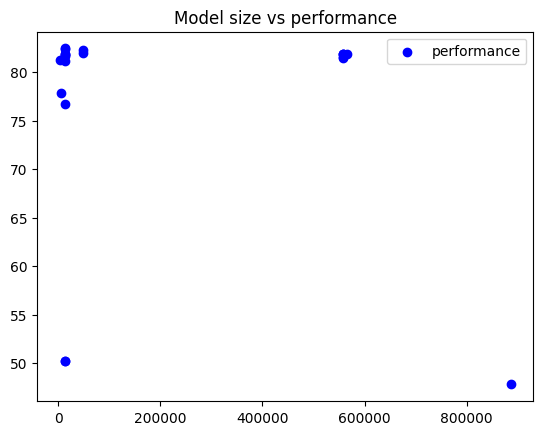

In [ ]:
x,y = [], []

for Model in model_results:
    x.append(Model[0])
    y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


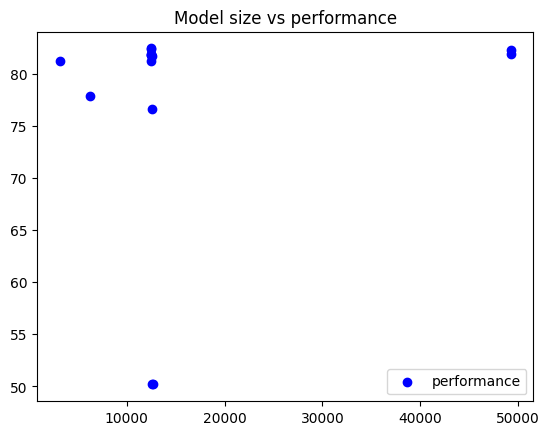

In [ ]:
x,y = [], []

for Model in model_results:
    if (Model[0] < 100000):
        x.append(Model[0])
        y.append(Model[1])

plt.scatter(x, y, label = 'performance', color="blue")

plt.title("Model size vs performance")
plt.legend()

plt.show()


In [ ]:
model_results

[(558081, 81.89),
 (558081, 81.84),
 (558081, 81.61),
 (558081, 81.47999999999999),
 (886529, 47.795),
 (558081, 81.82000000000001),
 (49281, 82.285),
 (49281, 81.94),
 (12593, 76.67),
 (12721, 50.185),
 (12593, 50.185),
 (12593, 81.695),
 (12481, 81.83),
 (12481, 81.865),
 (12481, 81.19),
 (6221, 77.85499999999999),
 (3149, 81.25),
 (12481, 81.77499999999999),
 (12481, 82.39),
 (12481, 82.44),
 (566273, 81.915)]

In [ ]:
model_family = []

In [ ]:
model_family.append(modeli)

In [ ]:
# X_train is my 80,000 x 768 BERT vectors
# y_train is my binary labels (0 or 1) with shape (100000, 1)

# Model architecture
modeli = Sequential()

# Input layer: (768,) is the shape of each BERT vector
modeli.add(Dense(256, input_dim=768, activation='relu'))
modeli.add(Dropout(0.3))  # Dropout to prevent overfitting
modeli.add(Dense(256, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(128, activation='gelu'))
modeli.add(Dropout(0.3))
modeli.add(Dense(64, activation='gelu'))
modeli.add(Dropout(0.3))

# Output layer: single neuron with sigmoid activation for binary classification
modeli.add(Dense(1, activation='sigmoid'))

# Compile the model
modeli.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Train the model
modeli.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
accuracy_val(modeli)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6159 - loss: 0.6571 - val_accuracy: 0.7678 - val_loss: 0.4872
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7593 - loss: 0.5025 - val_accuracy: 0.7991 - val_loss: 0.4347
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7923 - loss: 0.4523 - val_accuracy: 0.8106 - val_loss: 0.4160
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8089 - loss: 0.4274 - val_accuracy: 0.8184 - val_loss: 0.4032
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8107 - loss: 0.4178 - val_accuracy: 0.8191 - val_loss: 0.3979
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8224 - loss: 0.4007 - val_accuracy: 0.8225 - val_loss: 0.3949
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8266 - loss: 0.3911 - val_accuracy: 0.8234 - val_loss: 0.3916
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8340 - loss: 0.3773 - 

82.44500000000001

### Results

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


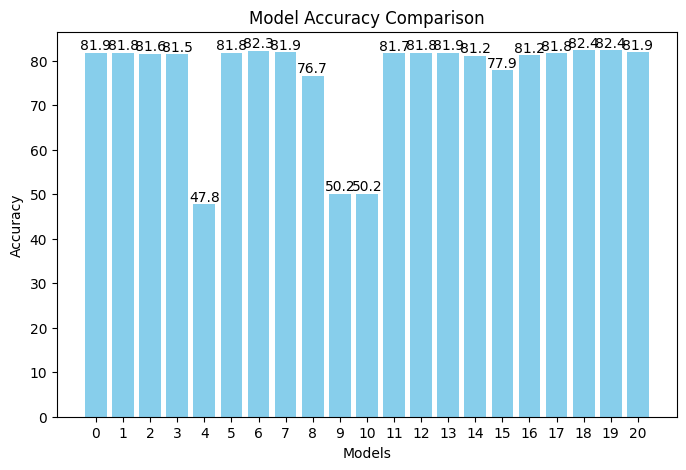

In [ ]:
# Given list of models
models = [model, model0, model1, model2, model3, 
          model4, model5, model6, model7, model8, 
          model9, model10, model11, model12, model13, 
          model14, model15, model16, model17, model18, 
          modeli]

# Compute accuracy values
accuracies = [accuracy_val(m) for m in models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(models))]

models_perf = pd.DataFrame({'model': models, 'accuracy': accuracies})

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


In [ ]:
float(np.mean(accuracies))

76.75738095238096

In [ ]:
float(np.median(accuracies))

81.77499999999999

In [ ]:
(float(np.min(accuracies)), float(np.max(accuracies)))

(47.795, 82.44)

### Drop Models 4,8,9,10,15

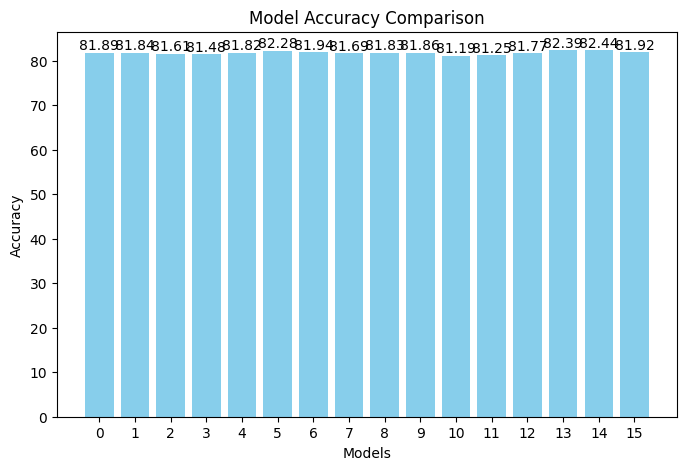

In [ ]:
# Drop rows where accuracy is less than 0.80
good_models_perf = models_perf[models_perf['accuracy'] >= 80]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(good_models_perf))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, good_models_perf.accuracy, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Show values on bars
for i, acc in enumerate(good_models_perf.accuracy):
    plt.text(i, acc, f"{acc:.1f}", ha='center', va='bottom')

# Display the plot
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


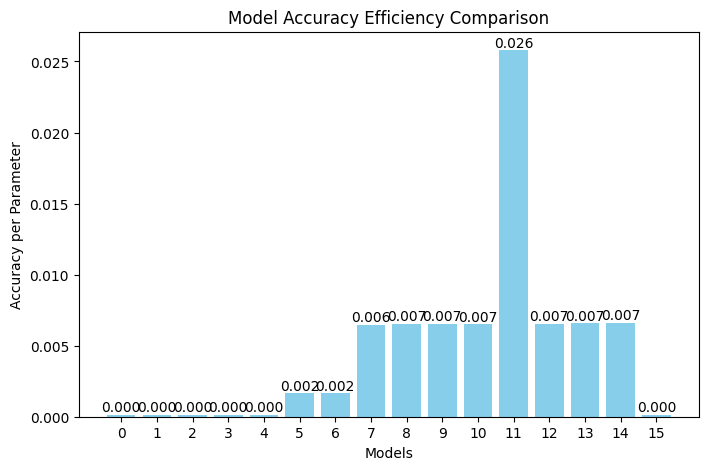

In [ ]:
# Given list of models
remaining_models = good_models_perf.model

# Compute accuracy per parameter values
accuracy_efficiencies = [accuracy_val(m)/(m.count_params()) for m in remaining_models]

# Generate model names as labels
model_names = [f"{i}" for i in range(len(remaining_models))]

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracy_efficiencies, color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Accuracy per Parameter")
plt.title("Model Accuracy Efficiency Comparison")

# Show values on bars
for i in range(len(accuracy_efficiencies)):
    acc = accuracy_efficiencies[i]
    plt.text(i, acc, f"{acc:.3f}", ha='center', va='bottom')

# Display the plot
plt.show()


### Best Performing and Efficient Deep Neural Network

In [ ]:
best_stats = (model15.count_params(), accuracy_train(model15), accuracy_val(model15))
print(f"Model has {best_stats[0]} parameters")
print(f"Model has train accuracy of {best_stats[1]}%,")
print(f"Model has test accuracy of {best_stats[2]}%,")

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step
Model has 3149 parameters
Model has train accuracy of 82.29875%,
Model has test accuracy of 81.25%,


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred3 = model15.predict(X_test) > 0.5
CM = confusion_matrix(y_test, y_pred3)
CM

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


array([[8199, 1790],
       [1786, 8225]])

In [ ]:
metrics(y_test, y_pred3, table = True, model_name="Neural Network")

,model,accuracy,precision,recall,f1_score
0,Neural Network,0.8212,0.8213,0.8216,0.8214


## K-Means++ & Deep Learning Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def sklearnKmeans_plus(X, k, m):
    '''
    X: numpy array, shape = [N, D]
    k: int value
    m: int value
    RETURN
        position: numpy array, shape = [N]
        centers: numpy array, shape = [k, D]
    '''
    position, centers = None, None
    ## start your code here
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=1, max_iter=m).fit(X)
    position, centers = kmeans.predict(X), kmeans.cluster_centers_
    
    # Compute WSS
    WSS = np.sum((X - centers[position])**2)
    
    return position, centers, WSS

In [ ]:
cluster_assignments = {}  # Dictionary to store assigned data points

wss_values = []  # Store WSS for each k
k_values = list(range(1, 11))  # k from 1 to 30

for k in k_values:
    print(f"at {k} k-value now")
    position, centers, WSS = sklearnKmeans_plus(X_train, k, 1000)
    
    # Store the WSS value for plotting
    wss_values.append(WSS)

    # Store cluster assignments (optional for later)
    cluster_assignments[k] = {
        "positions": position,
        "centers": centers,
        "WSS": WSS
    }


at 1 k-value now
at 2 k-value now
at 3 k-value now
at 4 k-value now
at 5 k-value now
at 6 k-value now
at 7 k-value now
at 8 k-value now
at 9 k-value now
at 10 k-value now


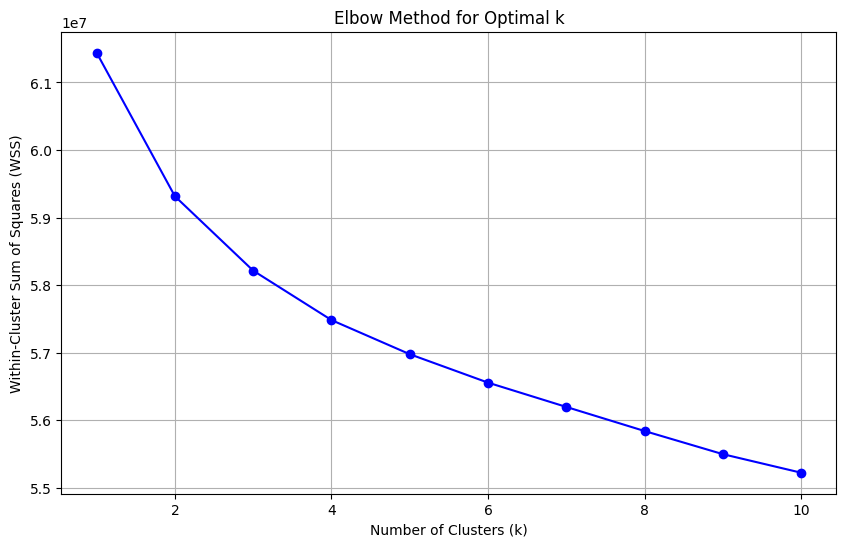

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)

plt.show()

Optimal k found at: 4


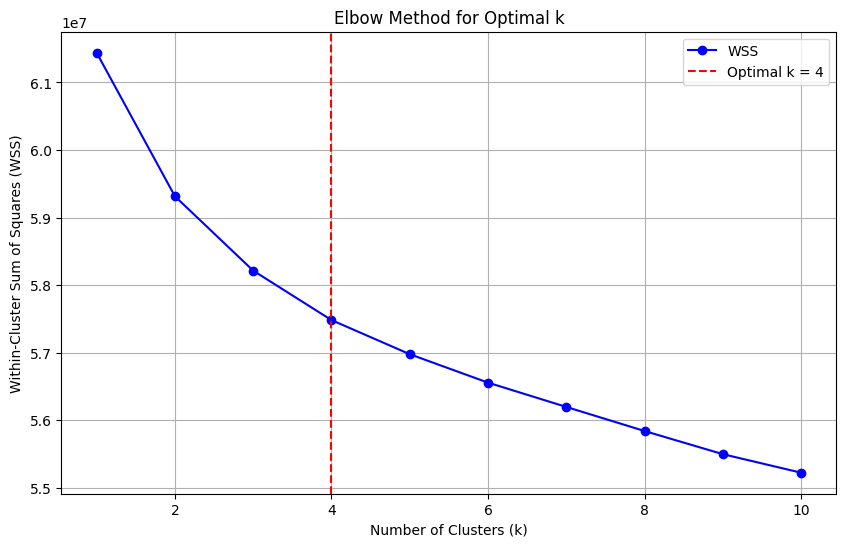

In [ ]:
from kneed import KneeLocator

knee_locator = KneeLocator(k_values, wss_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow

print(f"Optimal k found at: {optimal_k}")

# Plot again with optimal k highlighted
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss_values, marker='o', linestyle='-', color='b', label="WSS")
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method for Optimal k")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:

def train_dnn(X, Y, position, cluster):
    # Create a mask where the position matches the index
    mask = (position == cluster)

    # Apply mask to keep only the relevant Y values
    y_train = Y[mask]
    X_train = X[mask]
    
    # Remove zero entries
    X_train = X_train[~np.all(X_train == 0, axis=1)]
    y_train = y_train[~np.all(X_train == 0, axis=1)]  # Ensure y_train is aligned



    new_model = Sequential()
    new_model.add(Dense(4, input_dim=768, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    new_model.add(Dense(2, activation='mish'))
    new_model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # Output layer: single neuron with sigmoid activation for binary classification
    new_model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    new_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                                   patience=100,  # Number of epochs to wait before stopping if no improvement
                                   restore_best_weights=True,  # Restore the model weights from the epoch with the best performance
                                   verbose=1)

    # Train the model
    new_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    return new_model

In [ ]:
optimal_cluster = cluster_assignments[optimal_k]['positions']
optimal_cluster

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [ ]:
count = [i for i in range(4)]
for i in range(4):
    count[i] = int(sum(optimal_cluster == i))
count

[19006, 22582, 13982, 24430]

In [ ]:
cluster_models = {}  # Dictionary to store cluster-wise DNN models

# Train a separate Deep Neural Network for each cluster
for cluster in range(4):
    cluster_models[cluster] = train_dnn(X_train, y_train, optimal_cluster, cluster)

c:\Users\irvin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5571 - loss: 0.7516 - val_accuracy: 0.6491 - val_loss: 0.6170
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6443 - loss: 0.6320 - val_accuracy: 0.7215 - val_loss: 0.5541
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7020 - loss: 0.5820 - val_accuracy: 0.7446 - val_loss: 0.5221
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7170 - loss: 0.5576 - val_accuracy: 0.7635 - val_loss: 0.5045
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7224 - loss: 0.5529 - val_accuracy: 0.7641 - val_loss: 0.4951
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7383 - loss: 0.5350 - val_accuracy: 0.7709 - val_loss: 0.4866
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7332 - loss: 0.5272 - val_accuracy: 0.7777 - val_loss: 0.4808
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7398 - loss: 0.5242 - val_accu

### Inner Cluster Model Evaluation

In [ ]:
cluster_models

{0: <Sequential name=sequential_30, built=True>,
 1: <Sequential name=sequential_31, built=True>,
 2: <Sequential name=sequential_32, built=True>,
 3: <Sequential name=sequential_33, built=True>}

In [ ]:
cluster_models[2].count_params()

3089

In [ ]:
k_values = [i for i in range(1, 12, 2)]
scores = []

for k in k_values:
    print(f"at {k} k-value now")
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, optimal_cluster, cv=5)
    scores.append(np.mean(score))

at 1 k-value now
at 3 k-value now
at 5 k-value now
at 7 k-value now
at 9 k-value now
at 11 k-value now


Text(0, 0.5, 'Cross-Validation Score')

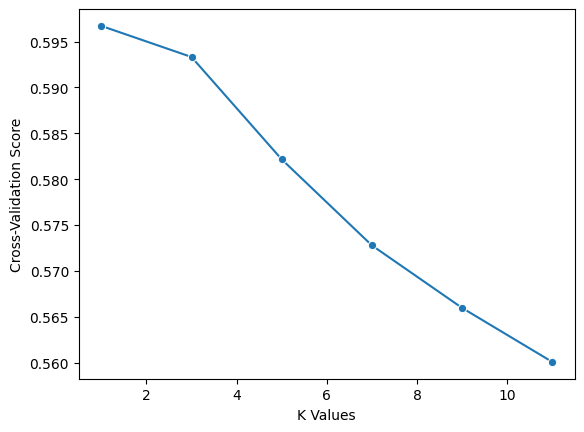

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Cross-Validation Score")

In [ ]:
optimal_kneighbour = k_values[scores.index(max(scores))]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=optimal_kneighbour)
knn.fit(X_train, optimal_cluster)
cluser_hat = knn.predict(X_test)

In [ ]:
N = len(y_test)
N

20000

In [ ]:
cluser_hat[0]

np.int32(3)

In [ ]:
X_test[0].shape

(768,)

In [ ]:

y_hat4 = [0 for i in range(N)]

for i in range(len(X_test)):
    x_i = X_test[i]
    cluster = cluser_hat[i]
    model = cluster_models[cluster]
    y_hat4[i] = model.predict(np.array([x_i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [ ]:
y_pred4 = (np.array(list(map(lambda x: x[0][0], y_hat4))) >= 0.5)

In [ ]:
float((sum((y_pred4 >= 0.5) == y_test)/len(y_test)))*100

81.0

## Results

In [ ]:
m1 = metrics(y_test, y_pred1, table = True, model_name="Random Forest")
m2 = metrics(y_test, y_pred2, table = True, model_name="K-NN")
m3 = metrics(y_test, y_pred3, table = True, model_name="Neural Network")
m4 = metrics(y_test, y_pred4, table = True, model_name="Custom NN")
final_results = pd.concat([m1,m2,m3,m4]).reset_index(drop=True)


In [ ]:
final_results

,model,accuracy,precision,recall,f1_score
0,Random Forest,0.7181,0.7178,0.7199,0.7188
1,K-NN,0.4938,0.4944,0.5012,0.4978
2,Neural Network,0.8212,0.8213,0.8216,0.8214
3,Custom NN,0.4946,0.4946,0.4505,0.4715
